# Notebook 05 : Modèles de Régression
## 6 Algorithmes de Régression avec MLflow Tracking

---

### Algorithmes implémentés :

| # | Algorithme | Type | Hyperparamètres |
|---|------------|------|------------------|
| 1 | **Ridge Regression** | Linéaire | alpha |
| 2 | **Lasso Regression** | Linéaire | alpha (feature selection) |
| 3 | **SVR (RBF)** | Kernel | C, gamma |
| 4 | **Random Forest** | Ensemble | n_estimators, max_depth |
| 5 | **XGBoost** | Boosting | n_estimators, learning_rate, max_depth |
| 6 | **Gradient Boosting** | Boosting | n_estimators, learning_rate, max_depth |

### Métriques évaluées :
- **MSE** : Mean Squared Error (plus bas = meilleur)
- **RMSE** : Root MSE (plus bas = meilleur)
- **MAE** : Mean Absolute Error (plus bas = meilleur)
- **R²** : Coefficient de détermination (plus élevé = meilleur)

---

**Variable cible :** Score de risque cardiovasculaire (risk_score) basé sur les indicateurs cliniques


## 1. Configuration et Imports

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Prétraitement
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

# Sklearn - Métriques
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sklearn - Modèles
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# XGBoost
from xgboost import XGBRegressor

# MLflow
import mlflow
import mlflow.sklearn

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

COLORS = {'primary': '#2E86AB', 'secondary': '#E74C3C', 'success': '#2ECC71', 
          'warning': '#F39C12', 'info': '#9B59B6', 'dark': '#34495E'}

print(f"Configuration terminée - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Configuration terminée - 2026-02-13 18:11:38


## 2. Configuration MLflow

In [2]:
# ============================================================================
# CONFIGURATION MLFLOW
# ============================================================================

mlflow.set_tracking_uri("file:./mlruns")
EXPERIMENT_NAME = "Heart_Disease_Regression"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow Experiment: {EXPERIMENT_NAME} (ID: {experiment_id})")

MLflow Experiment: Heart_Disease_Regression (ID: 971096631646366527)


## 3. Chargement et Préparation des Données

In [3]:
# ============================================================================
# CHARGEMENT ET CRÉATION DE LA VARIABLE CIBLE CONTINUE
# ============================================================================

df = pd.read_csv('heart.csv')
print(f"Dataset chargé: {df.shape[0]} patients x {df.shape[1]} variables")

# Créer un score de risque cardiovasculaire continu (0-100)
# Basé sur les facteurs de risque cliniques pondérés
def calculate_risk_score(row):
    """Calcule un score de risque cardiovasculaire continu (0-100)."""
    score = 0
    
    # Age (contribue jusqu'à 25 points)
    score += min((row['age'] - 29) / (77 - 29) * 25, 25)
    
    # Pression artérielle (jusqu'à 20 points)
    if row['trestbps'] > 140:
        score += min((row['trestbps'] - 140) / 60 * 20, 20)
    
    # Cholestérol (jusqu'à 15 points)
    if row['chol'] > 200:
        score += min((row['chol'] - 200) / 300 * 15, 15)
    
    # Fréquence cardiaque max inversée (jusqu'à 15 points)
    # Thalach bas = risque plus élevé
    score += max((200 - row['thalach']) / 130 * 15, 0)
    
    # Oldpeak - dépression ST (jusqu'à 10 points)
    score += min(row['oldpeak'] / 6.2 * 10, 10)
    
    # Facteurs catégoriels
    score += row['exang'] * 5  # Angine à l'effort (+5)
    score += row['fbs'] * 3    # Glycémie élevée (+3)
    score += row['sex'] * 2    # Homme (+2)
    score += row['ca'] * 2     # Vaisseaux (+2 par vaisseau)
    
    # Normaliser entre 0 et 100
    return min(max(score, 0), 100)

# Appliquer le calcul
df['risk_score'] = df.apply(calculate_risk_score, axis=1)

print(f"\nVariable cible créée: risk_score")
print(f"  - Min: {df['risk_score'].min():.2f}")
print(f"  - Max: {df['risk_score'].max():.2f}")
print(f"  - Moyenne: {df['risk_score'].mean():.2f}")
print(f"  - Écart-type: {df['risk_score'].std():.2f}")

Dataset chargé: 1025 patients x 14 variables

Variable cible créée: risk_score
  - Min: 2.20
  - Max: 64.64
  - Moyenne: 29.56
  - Écart-type: 10.95


In [4]:
# ============================================================================
# SÉPARATION FEATURES / TARGET
# ============================================================================

# Features (exclure target binaire et risk_score)
X = df.drop(['target', 'risk_score'], axis=1)
y = df['risk_score']
feature_names = X.columns.tolist()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features: {len(feature_names)}")
print(f"Train: {X_train_scaled.shape[0]} | Test: {X_test_scaled.shape[0]}")

Features: 13
Train: 820 | Test: 205


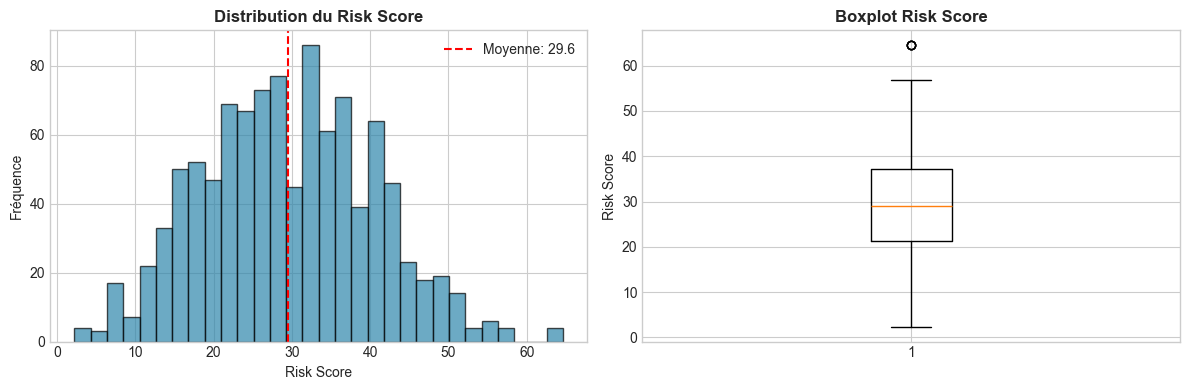

In [5]:
# Visualisation de la distribution de risk_score
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.hist(y, bins=30, color=COLORS['primary'], edgecolor='black', alpha=0.7)
ax1.axvline(y.mean(), color='red', linestyle='--', label=f'Moyenne: {y.mean():.1f}')
ax1.set_xlabel('Risk Score')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution du Risk Score', fontweight='bold')
ax1.legend()

ax2 = axes[1]
ax2.boxplot(y, vert=True)
ax2.set_ylabel('Risk Score')
ax2.set_title('Boxplot Risk Score', fontweight='bold')

plt.tight_layout()
plt.savefig('images/risk_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Fonctions Utilitaires

In [6]:
# ============================================================================
# FONCTIONS D'ÉVALUATION
# ============================================================================

def calculate_regression_metrics(y_true, y_pred):
    """Calcule toutes les métriques de régression."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}


def evaluate_and_log_model(model, model_name, X_train, X_test, y_train, y_test, 
                           best_params=None, grid_search_time=0):
    """
    Entraîne, évalue et log un modèle de régression dans MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        
        # Entraînement
        start_train = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_train
        
        # Prédictions
        start_infer = time.time()
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        infer_time = time.time() - start_infer
        
        # Métriques
        train_metrics = calculate_regression_metrics(y_train, y_pred_train)
        test_metrics = calculate_regression_metrics(y_test, y_pred_test)
        
        # Cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
        
        # Log paramètres
        mlflow.log_param("model_name", model_name)
        if best_params:
            for key, value in best_params.items():
                mlflow.log_param(key, value)
        
        # Log métriques train
        mlflow.log_metric("train_mse", train_metrics['mse'])
        mlflow.log_metric("train_rmse", train_metrics['rmse'])
        mlflow.log_metric("train_mae", train_metrics['mae'])
        mlflow.log_metric("train_r2", train_metrics['r2'])
        
        # Log métriques test
        mlflow.log_metric("test_mse", test_metrics['mse'])
        mlflow.log_metric("test_rmse", test_metrics['rmse'])
        mlflow.log_metric("test_mae", test_metrics['mae'])
        mlflow.log_metric("test_r2", test_metrics['r2'])
        
        # Log CV et temps
        mlflow.log_metric("cv_r2_mean", cv_scores.mean())
        mlflow.log_metric("cv_r2_std", cv_scores.std())
        mlflow.log_metric("train_time", train_time)
        mlflow.log_metric("inference_time", infer_time)
        mlflow.log_metric("grid_search_time", grid_search_time)
        
        # Log modèle
        mlflow.sklearn.log_model(model, model_name)
        
        # Résultats
        results = {
            'model': model_name,
            'train_mse': train_metrics['mse'],
            'train_r2': train_metrics['r2'],
            'test_mse': test_metrics['mse'],
            'test_rmse': test_metrics['rmse'],
            'test_mae': test_metrics['mae'],
            'test_r2': test_metrics['r2'],
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std(),
            'train_time': train_time,
            'y_pred': y_pred_test,
            'best_params': best_params
        }
        
        print(f"\u2705 {model_name}: R²={test_metrics['r2']:.4f}, RMSE={test_metrics['rmse']:.4f}, MAE={test_metrics['mae']:.4f}")
        
        return results, model

# Stockage
all_results = []
trained_models = {}

print("Fonctions d'évaluation définies.")

Fonctions d'évaluation définies.


---

## 5. Modèle 1 : Ridge Regression

In [7]:
print("="*70)
print("MODÈLE 1 : RIDGE REGRESSION")
print("="*70)

# Grid Search
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

start_gs = time.time()
ridge_gs = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    ridge_params, cv=5, scoring='r2', n_jobs=-1
)
ridge_gs.fit(X_train_scaled, y_train)
gs_time = time.time() - start_gs

print(f"Meilleurs paramètres: {ridge_gs.best_params_}")
print(f"Meilleur score CV: {ridge_gs.best_score_:.4f}")

# Entraîner avec meilleurs params
ridge_best = Ridge(**ridge_gs.best_params_, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    ridge_best, "Ridge_Regression", X_train_scaled, X_test_scaled, y_train, y_test,
    ridge_gs.best_params_, gs_time
)
all_results.append(results)
trained_models['Ridge'] = model

MODÈLE 1 : RIDGE REGRESSION
Meilleurs paramètres: {'alpha': 1}
Meilleur score CV: 0.9698


2026/02/13 18:11:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Ridge_Regression: R²=0.9684, RMSE=1.9072, MAE=1.4364


## 6. Modèle 2 : Lasso Regression

In [8]:
print("\n" + "="*70)
print("MODÈLE 2 : LASSO REGRESSION")
print("="*70)

# Grid Search
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

start_gs = time.time()
lasso_gs = GridSearchCV(
    Lasso(random_state=RANDOM_STATE, max_iter=10000),
    lasso_params, cv=5, scoring='r2', n_jobs=-1
)
lasso_gs.fit(X_train_scaled, y_train)
gs_time = time.time() - start_gs

print(f"Meilleurs paramètres: {lasso_gs.best_params_}")
print(f"Meilleur score CV: {lasso_gs.best_score_:.4f}")

# Entraîner
lasso_best = Lasso(**lasso_gs.best_params_, random_state=RANDOM_STATE, max_iter=10000)
results, model = evaluate_and_log_model(
    lasso_best, "Lasso_Regression", X_train_scaled, X_test_scaled, y_train, y_test,
    lasso_gs.best_params_, gs_time
)
all_results.append(results)
trained_models['Lasso'] = model

# Afficher coefficients (feature selection)
print("\nCoefficients Lasso (features sélectionnées):")
lasso_coef = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_})
lasso_coef = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
print(f"  Features non-nulles: {len(lasso_coef)}/{len(feature_names)}")
display(lasso_coef)


MODÈLE 2 : LASSO REGRESSION
Meilleurs paramètres: {'alpha': 0.001}
Meilleur score CV: 0.9698


2026/02/13 18:12:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Lasso_Regression: R²=0.9684, RMSE=1.9079, MAE=1.4372

Coefficients Lasso (features sélectionnées):
  Features non-nulles: 13/13


,Feature,Coefficient
0,age,4.815026
7,thalach,-2.778898
8,exang,2.539878
3,trestbps,2.424024
4,chol,2.144393
11,ca,2.003258
9,oldpeak,1.733220
5,fbs,1.131817
1,sex,0.818047
6,restecg,0.097706


## 7. Modèle 3 : SVR (RBF Kernel)

In [9]:
print("\n" + "="*70)
print("MODÈLE 3 : SVR (RBF KERNEL)")
print("="*70)

# Grid Search
svr_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

start_gs = time.time()
svr_gs = GridSearchCV(
    SVR(kernel='rbf'),
    svr_params, cv=5, scoring='r2', n_jobs=-1
)
svr_gs.fit(X_train_scaled, y_train)
gs_time = time.time() - start_gs

print(f"Meilleurs paramètres: {svr_gs.best_params_}")
print(f"Meilleur score CV: {svr_gs.best_score_:.4f}")

# Entraîner
svr_best = SVR(kernel='rbf', **svr_gs.best_params_)
results, model = evaluate_and_log_model(
    svr_best, "SVR_RBF", X_train_scaled, X_test_scaled, y_train, y_test,
    svr_gs.best_params_, gs_time
)
all_results.append(results)
trained_models['SVR_RBF'] = model


MODÈLE 3 : SVR (RBF KERNEL)
Meilleurs paramètres: {'C': 100, 'gamma': 0.01}
Meilleur score CV: 0.9965


2026/02/13 18:12:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ SVR_RBF: R²=0.9969, RMSE=0.6010, MAE=0.3761


## 8. Modèle 4 : Random Forest Regressor

In [10]:
print("\n" + "="*70)
print("MODÈLE 4 : RANDOM FOREST REGRESSOR")
print("="*70)

# Grid Search
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

start_gs = time.time()
rf_gs = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    rf_params, cv=5, scoring='r2', n_jobs=-1
)
rf_gs.fit(X_train_scaled, y_train)
gs_time = time.time() - start_gs

print(f"Meilleurs paramètres: {rf_gs.best_params_}")
print(f"Meilleur score CV: {rf_gs.best_score_:.4f}")

# Entraîner
rf_best = RandomForestRegressor(**rf_gs.best_params_, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    rf_best, "Random_Forest_Regressor", X_train_scaled, X_test_scaled, y_train, y_test,
    rf_gs.best_params_, gs_time
)
all_results.append(results)
trained_models['Random_Forest'] = model


MODÈLE 4 : RANDOM FOREST REGRESSOR
Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score CV: 0.9828


2026/02/13 18:12:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Random_Forest_Regressor: R²=0.9920, RMSE=0.9590, MAE=0.5839


## 9. Modèle 5 : XGBoost Regressor

In [11]:
print("\n" + "="*70)
print("MODÈLE 5 : XGBOOST REGRESSOR")
print("="*70)

# Grid Search
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

start_gs = time.time()
xgb_gs = GridSearchCV(
    XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
    xgb_params, cv=5, scoring='r2', n_jobs=-1
)
xgb_gs.fit(X_train_scaled, y_train)
gs_time = time.time() - start_gs

print(f"Meilleurs paramètres: {xgb_gs.best_params_}")
print(f"Meilleur score CV: {xgb_gs.best_score_:.4f}")

# Entraîner
xgb_best = XGBRegressor(**xgb_gs.best_params_, random_state=RANDOM_STATE, verbosity=0)
results, model = evaluate_and_log_model(
    xgb_best, "XGBoost_Regressor", X_train_scaled, X_test_scaled, y_train, y_test,
    xgb_gs.best_params_, gs_time
)
all_results.append(results)
trained_models['XGBoost'] = model


MODÈLE 5 : XGBOOST REGRESSOR
Meilleurs paramètres: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Meilleur score CV: 0.9949


2026/02/13 18:13:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ XGBoost_Regressor: R²=0.9985, RMSE=0.4093, MAE=0.2493


## 10. Modèle 6 : Gradient Boosting Regressor

In [12]:
print("\n" + "="*70)
print("MODÈLE 6 : GRADIENT BOOSTING REGRESSOR")
print("="*70)

# Grid Search
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

start_gs = time.time()
gb_gs = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    gb_params, cv=5, scoring='r2', n_jobs=-1
)
gb_gs.fit(X_train_scaled, y_train)
gs_time = time.time() - start_gs

print(f"Meilleurs paramètres: {gb_gs.best_params_}")
print(f"Meilleur score CV: {gb_gs.best_score_:.4f}")

# Entraîner
gb_best = GradientBoostingRegressor(**gb_gs.best_params_, random_state=RANDOM_STATE)
results, model = evaluate_and_log_model(
    gb_best, "Gradient_Boosting_Regressor", X_train_scaled, X_test_scaled, y_train, y_test,
    gb_gs.best_params_, gs_time
)
all_results.append(results)
trained_models['Gradient_Boosting'] = model

print(f"\n\u2705 Total: {len(all_results)} modèles entraînés")


MODÈLE 6 : GRADIENT BOOSTING REGRESSOR
Meilleurs paramètres: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Meilleur score CV: 0.9955


2026/02/13 18:13:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Gradient_Boosting_Regressor: R²=0.9987, RMSE=0.3910, MAE=0.2265

✅ Total: 6 modèles entraînés


---

## 11. Tableau Comparatif

In [13]:
# ============================================================================
# TABLEAU COMPARATIF
# ============================================================================

print("="*70)
print("TABLEAU COMPARATIF DES 6 MODÈLES DE RÉGRESSION")
print("="*70)

comparison_df = pd.DataFrame([{
    'Model': r['model'],
    'Test MSE': r['test_mse'],
    'Test RMSE': r['test_rmse'],
    'Test MAE': r['test_mae'],
    'Test R²': r['test_r2'],
    'CV R² Mean': r['cv_r2_mean'],
    'CV R² Std': r['cv_r2_std'],
    'Train Time': r['train_time']
} for r in all_results])

comparison_df = comparison_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

display(comparison_df.style.format({
    'Test MSE': '{:.4f}',
    'Test RMSE': '{:.4f}',
    'Test MAE': '{:.4f}',
    'Test R²': '{:.4f}',
    'CV R² Mean': '{:.4f}',
    'CV R² Std': '{:.4f}',
    'Train Time': '{:.4f}'
}).background_gradient(subset=['Test R²'], cmap='Greens')
 .background_gradient(subset=['Test RMSE'], cmap='Reds_r'))

TABLEAU COMPARATIF DES 6 MODÈLES DE RÉGRESSION


,Model,Test MSE,Test RMSE,Test MAE,Test R²,CV R² Mean,CV R² Std,Train Time
0,Gradient_Boosting_Regressor,0.1529,0.3910,0.2265,0.9987,0.9929,0.0034,0.2837
1,XGBoost_Regressor,0.1675,0.4093,0.2493,0.9985,0.9926,0.0042,0.1340
2,SVR_RBF,0.3612,0.6010,0.3761,0.9969,0.9963,0.0012,0.2287
3,Random_Forest_Regressor,0.9196,0.9590,0.5839,0.9920,0.9815,0.0064,0.7873
4,Ridge_Regression,3.6375,1.9072,1.4364,0.9684,0.9693,0.0037,0.0000
5,Lasso_Regression,3.6401,1.9079,1.4372,0.9684,0.9693,0.0038,0.0053


## 12. Visualisations Comparatives

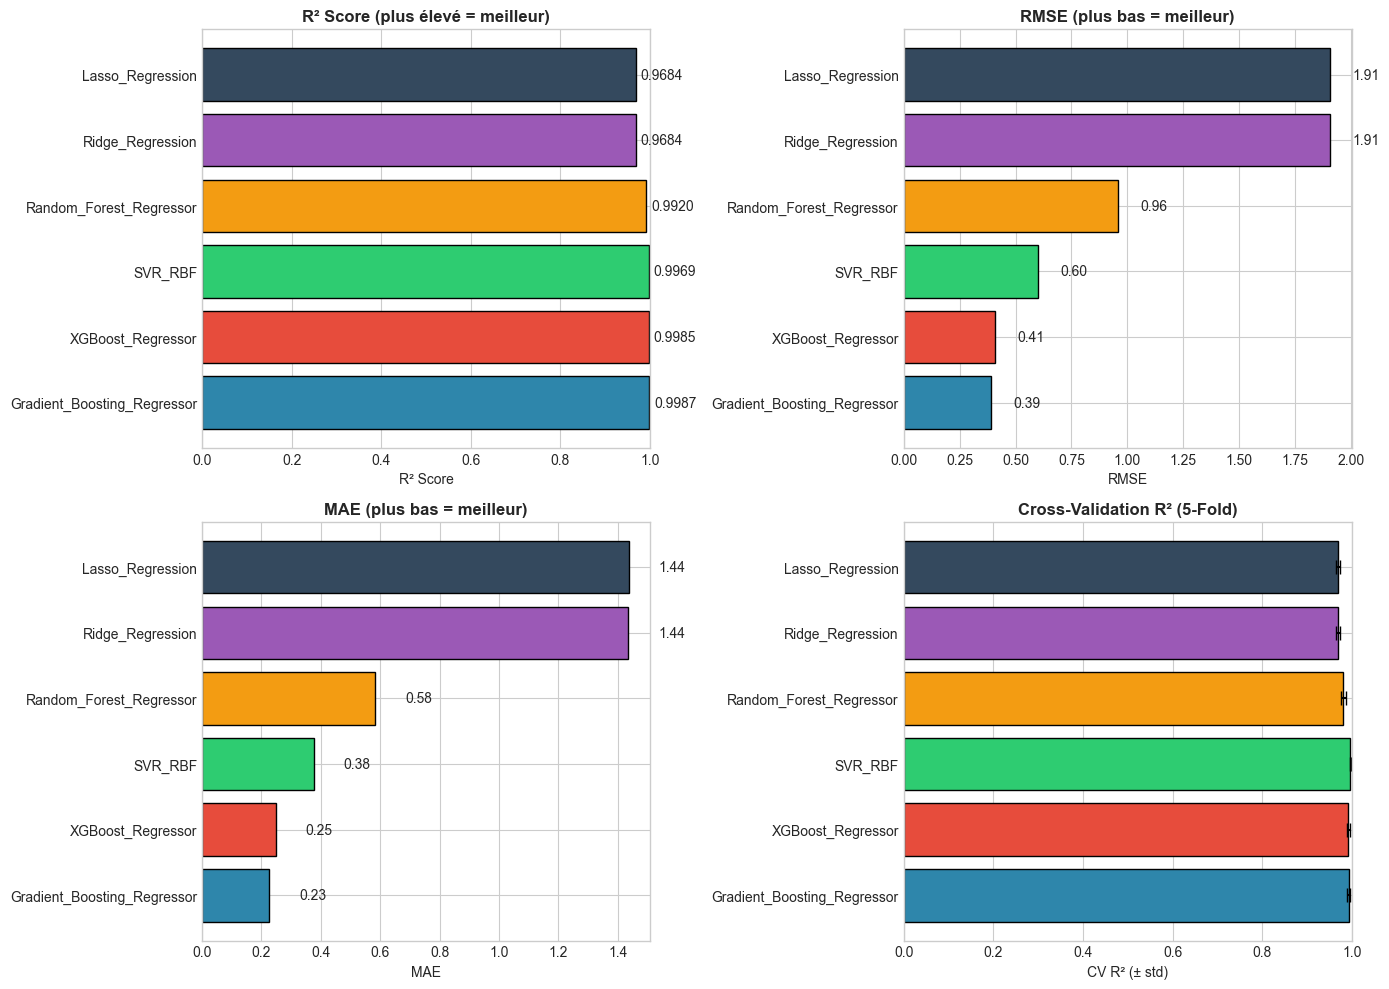

In [14]:
# ============================================================================
# COMPARAISON DES MÉTRIQUES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = comparison_df['Model'].tolist()
colors = [COLORS['primary'], COLORS['secondary'], COLORS['success'], 
          COLORS['warning'], COLORS['info'], COLORS['dark']]

# 1. R² Score
ax1 = axes[0, 0]
bars = ax1.barh(models, comparison_df['Test R²'], color=colors, edgecolor='black')
ax1.set_xlabel('R² Score')
ax1.set_title('R² Score (plus élevé = meilleur)', fontweight='bold')
ax1.set_xlim(0, 1)
for bar, val in zip(bars, comparison_df['Test R²']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')

# 2. RMSE
ax2 = axes[0, 1]
bars = ax2.barh(models, comparison_df['Test RMSE'], color=colors, edgecolor='black')
ax2.set_xlabel('RMSE')
ax2.set_title('RMSE (plus bas = meilleur)', fontweight='bold')
for bar, val in zip(bars, comparison_df['Test RMSE']):
    ax2.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center')

# 3. MAE
ax3 = axes[1, 0]
bars = ax3.barh(models, comparison_df['Test MAE'], color=colors, edgecolor='black')
ax3.set_xlabel('MAE')
ax3.set_title('MAE (plus bas = meilleur)', fontweight='bold')
for bar, val in zip(bars, comparison_df['Test MAE']):
    ax3.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center')

# 4. CV R²
ax4 = axes[1, 1]
ax4.barh(models, comparison_df['CV R² Mean'], xerr=comparison_df['CV R² Std'],
         color=colors, edgecolor='black', capsize=5)
ax4.set_xlabel('CV R² (± std)')
ax4.set_title('Cross-Validation R² (5-Fold)', fontweight='bold')
ax4.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('images/regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Predicted vs Actual

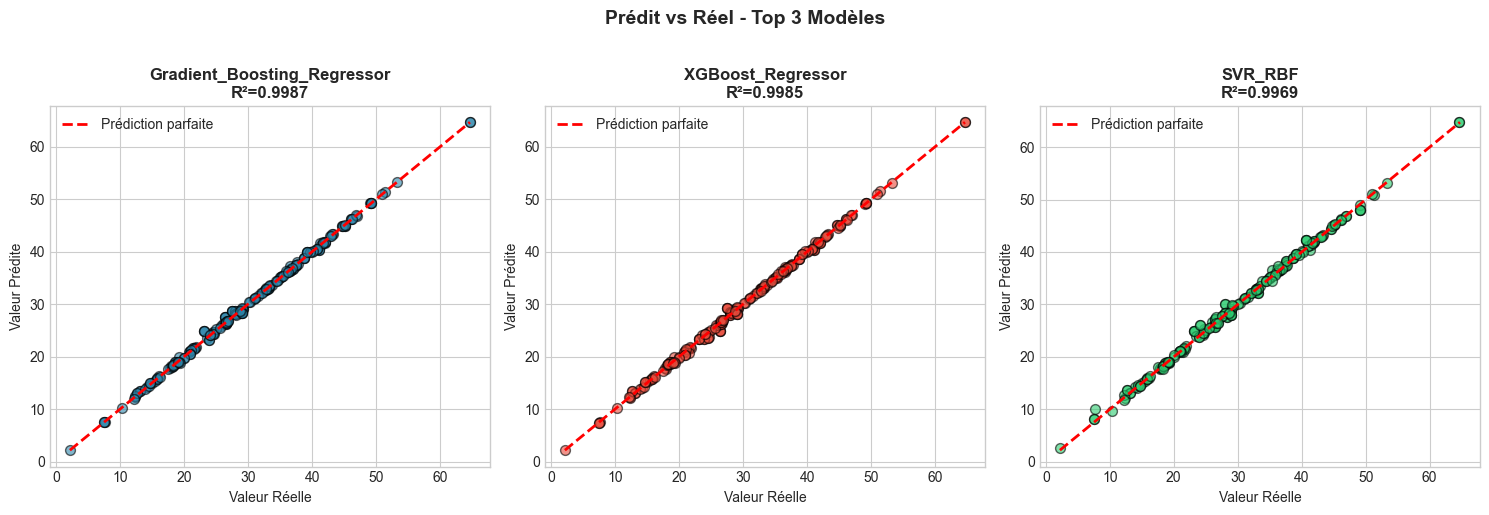

In [15]:
# ============================================================================
# PREDICTED VS ACTUAL - TOP 3 MODÈLES
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

top_3 = comparison_df.head(3)['Model'].tolist()

for idx, model_name in enumerate(top_3):
    ax = axes[idx]
    
    result = next(r for r in all_results if r['model'] == model_name)
    y_pred = result['y_pred']
    
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolor='black', s=50, c=colors[idx])
    
    # Ligne parfaite
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')
    
    ax.set_xlabel('Valeur Réelle')
    ax.set_ylabel('Valeur Prédite')
    ax.set_title(f'{model_name}\nR²={result["test_r2"]:.4f}', fontweight='bold')
    ax.legend()

plt.suptitle('Prédit vs Réel - Top 3 Modèles', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Analyse des Résidus

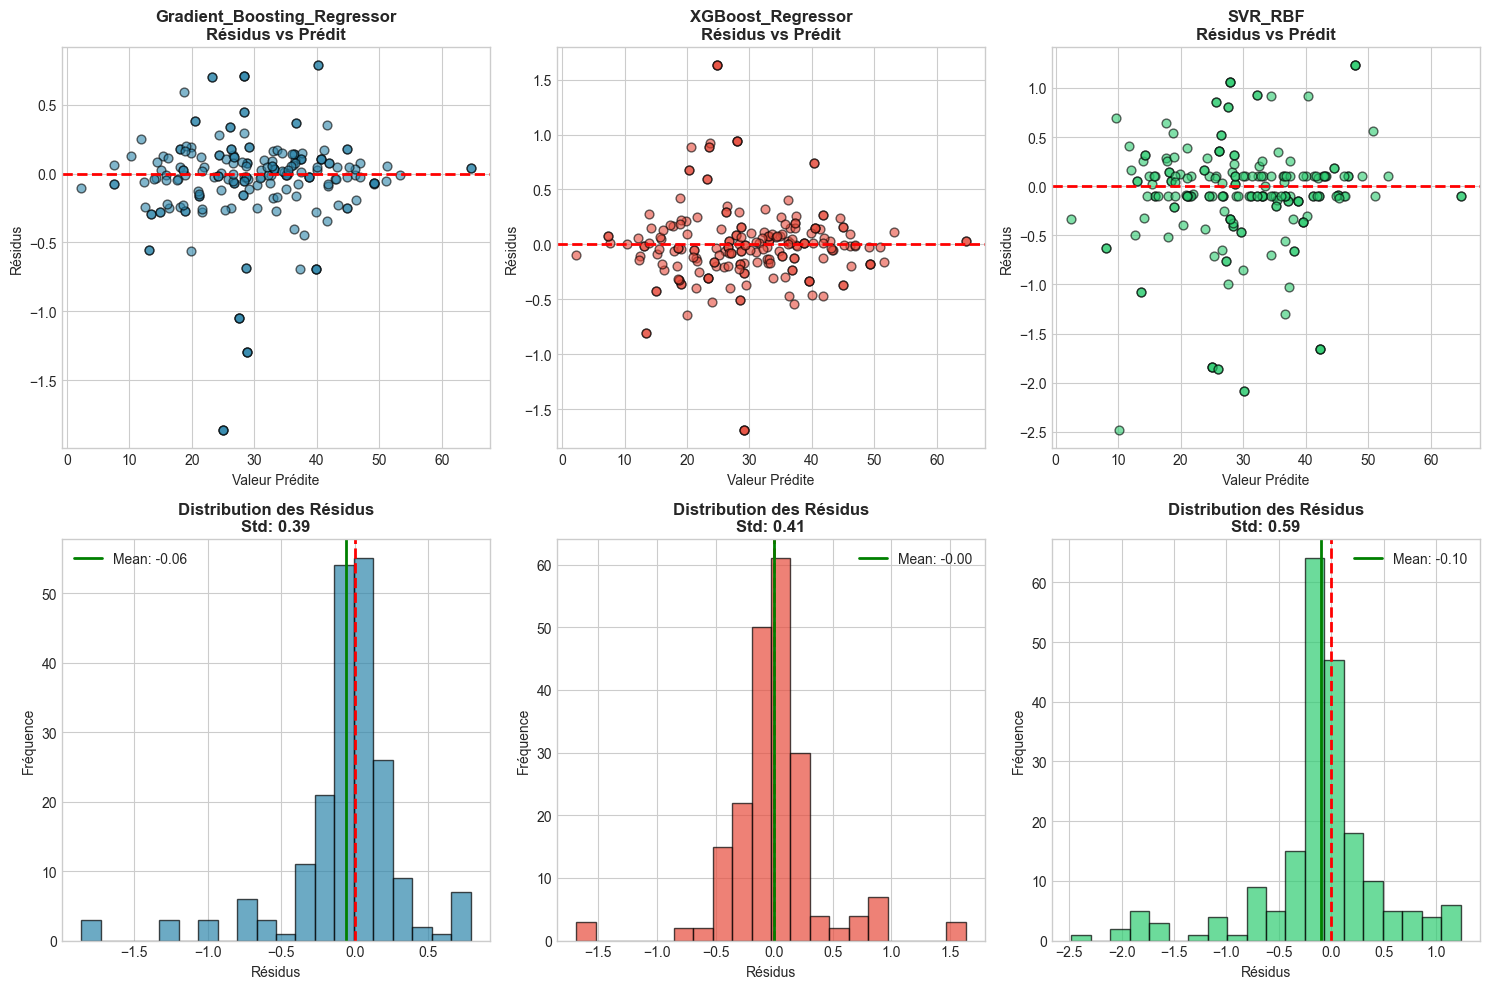

In [16]:
# ============================================================================
# ANALYSE DES RÉSIDUS - TOP 3 MODÈLES
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, model_name in enumerate(top_3):
    result = next(r for r in all_results if r['model'] == model_name)
    y_pred = result['y_pred']
    residuals = y_test.values - y_pred
    
    # Residuals vs Predicted
    ax1 = axes[0, idx]
    ax1.scatter(y_pred, residuals, alpha=0.6, edgecolor='black', s=40, c=colors[idx])
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Valeur Prédite')
    ax1.set_ylabel('Résidus')
    ax1.set_title(f'{model_name}\nRésidus vs Prédit', fontweight='bold')
    
    # Distribution des résidus
    ax2 = axes[1, idx]
    ax2.hist(residuals, bins=20, color=colors[idx], edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=residuals.mean(), color='green', linestyle='-', 
                linewidth=2, label=f'Mean: {residuals.mean():.2f}')
    ax2.set_xlabel('Résidus')
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution des Résidus\nStd: {residuals.std():.2f}', fontweight='bold')
    ax2.legend()

plt.tight_layout()
plt.savefig('images/residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 15. Feature Importance

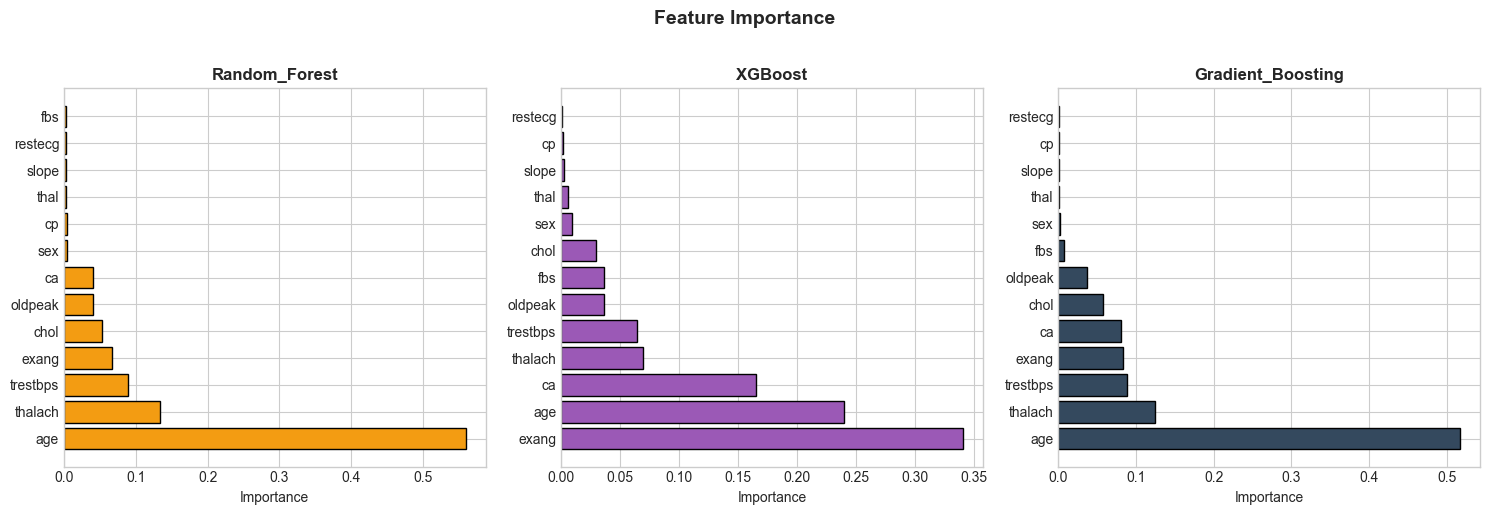

In [17]:
# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

importance_models = [
    ('Random_Forest', trained_models['Random_Forest']),
    ('XGBoost', trained_models['XGBoost']),
    ('Gradient_Boosting', trained_models['Gradient_Boosting'])
]

for idx, (name, model) in enumerate(importance_models):
    ax = axes[idx]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    ax.barh([feature_names[i] for i in indices], importances[indices], 
            color=colors[idx+3], edgecolor='black')
    ax.set_xlabel('Importance')
    ax.set_title(f'{name}', fontweight='bold')

plt.suptitle('Feature Importance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/feature_importance_regression.png', dpi=300, bbox_inches='tight')
plt.show()

## 16. Dashboard et Sauvegarde

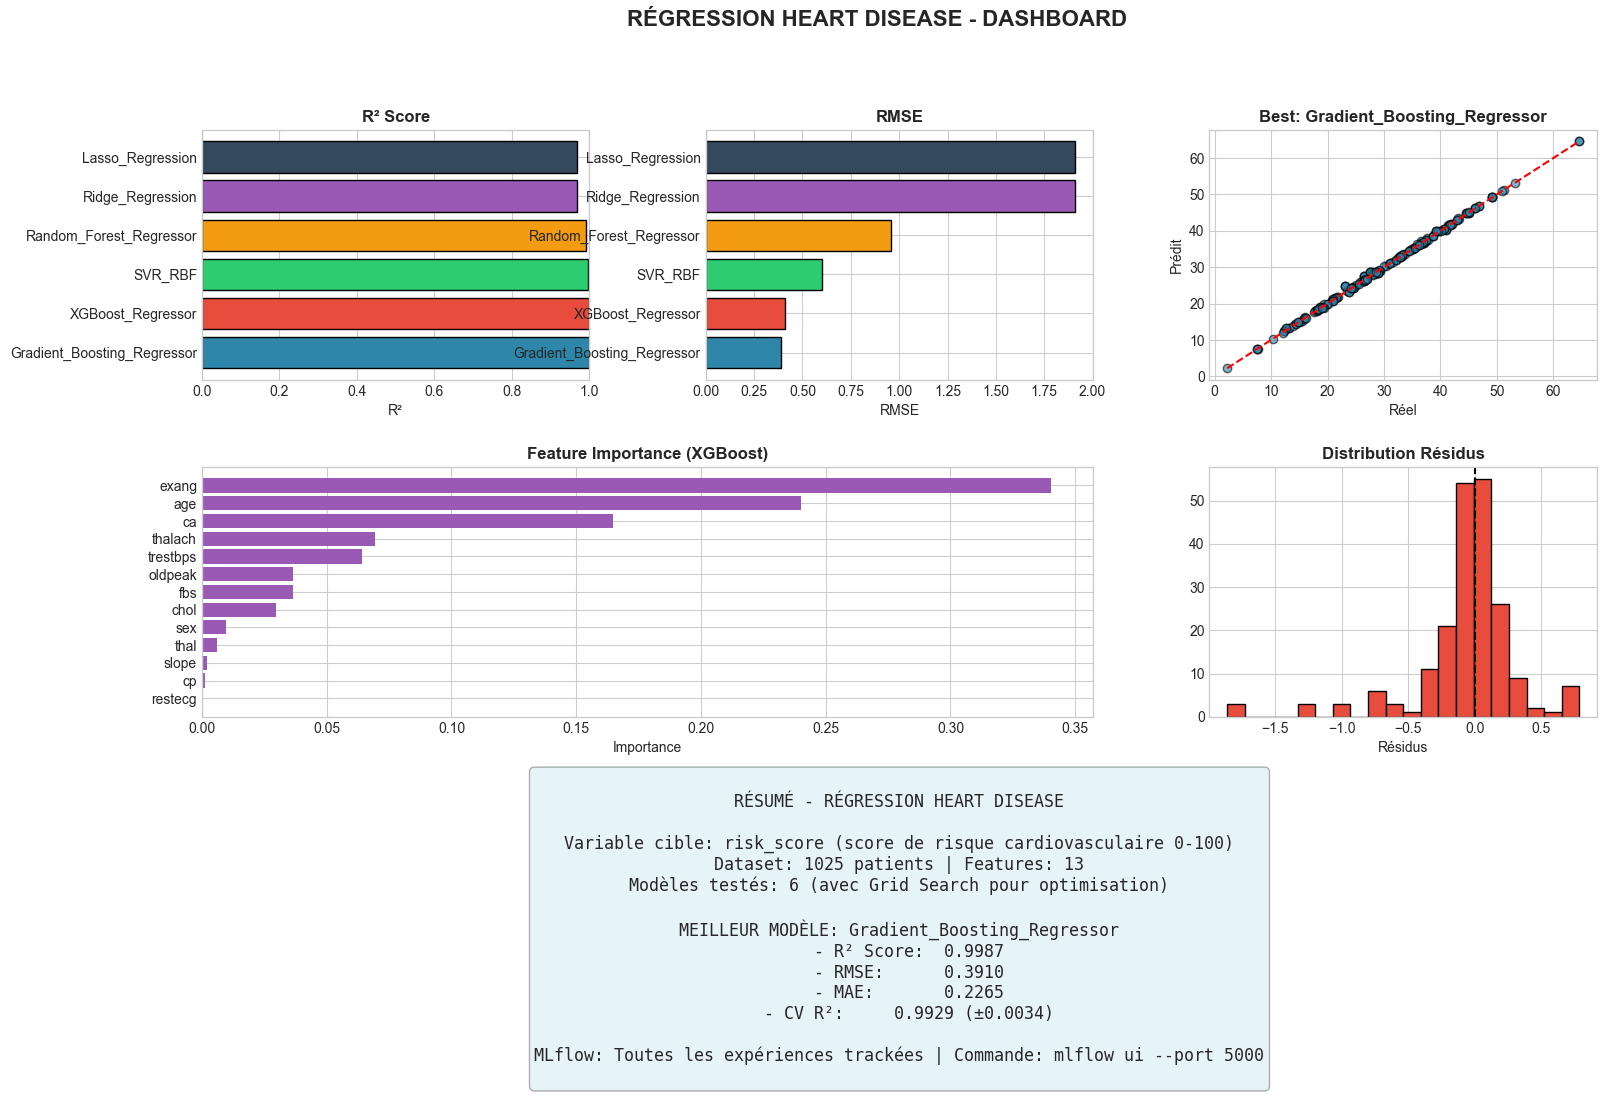

In [18]:
# ============================================================================
# DASHBOARD FINAL
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. R² Comparison
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.barh(comparison_df['Model'], comparison_df['Test R²'], 
                color=colors, edgecolor='black')
ax1.set_xlabel('R²')
ax1.set_title('R² Score', fontweight='bold')
ax1.set_xlim(0, 1)

# 2. RMSE Comparison
ax2 = fig.add_subplot(gs[0, 1])
ax2.barh(comparison_df['Model'], comparison_df['Test RMSE'], color=colors, edgecolor='black')
ax2.set_xlabel('RMSE')
ax2.set_title('RMSE', fontweight='bold')

# 3. Best model - Predicted vs Actual
ax3 = fig.add_subplot(gs[0, 2])
best_model = comparison_df.iloc[0]['Model']
best_result = next(r for r in all_results if r['model'] == best_model)
ax3.scatter(y_test, best_result['y_pred'], alpha=0.6, c=COLORS['primary'], edgecolor='black')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax3.set_xlabel('Réel')
ax3.set_ylabel('Prédit')
ax3.set_title(f'Best: {best_model}', fontweight='bold')

# 4. Feature importance (best ensemble model)
ax4 = fig.add_subplot(gs[1, 0:2])
best_ensemble = trained_models['XGBoost']
importances = best_ensemble.feature_importances_
indices = np.argsort(importances)
ax4.barh([feature_names[i] for i in indices], importances[indices], color=COLORS['info'])
ax4.set_xlabel('Importance')
ax4.set_title('Feature Importance (XGBoost)', fontweight='bold')

# 5. Residuals
ax5 = fig.add_subplot(gs[1, 2])
residuals = y_test.values - best_result['y_pred']
ax5.hist(residuals, bins=20, color=COLORS['secondary'], edgecolor='black')
ax5.axvline(x=0, color='black', linestyle='--')
ax5.set_xlabel('Résidus')
ax5.set_title('Distribution Résidus', fontweight='bold')

# 6. Summary
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')
best = comparison_df.iloc[0]
summary = f"""
RÉSUMÉ - RÉGRESSION HEART DISEASE

Variable cible: risk_score (score de risque cardiovasculaire 0-100)
Dataset: {len(X)} patients | Features: {len(feature_names)}
Modèles testés: 6 (avec Grid Search pour optimisation)

MEILLEUR MODÈLE: {best['Model']}
  - R² Score:  {best['Test R²']:.4f}
  - RMSE:      {best['Test RMSE']:.4f}
  - MAE:       {best['Test MAE']:.4f}
  - CV R²:     {best['CV R² Mean']:.4f} (±{best['CV R² Std']:.4f})

MLflow: Toutes les expériences trackées | Commande: mlflow ui --port 5000
"""
ax6.text(0.5, 0.5, summary, transform=ax6.transAxes, fontsize=12,
         ha='center', va='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('RÉGRESSION HEART DISEASE - DASHBOARD', fontsize=16, fontweight='bold', y=0.98)
plt.savefig('images/regression_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# ============================================================================
# SAUVEGARDE
# ============================================================================

comparison_df.to_csv('regression_results.csv', index=False)
print("\u2705 Résultats sauvegardés: regression_results.csv")

import joblib
import os
os.makedirs('models', exist_ok=True)
for name, model in trained_models.items():
    joblib.dump(model, f'models/{name}_regressor.pkl')
print(f"\u2705 {len(trained_models)} modèles sauvegardés")

print("\n" + "="*70)
print("RÉGRESSION TERMINÉE AVEC SUCCÈS !")
print("="*70)

✅ Résultats sauvegardés: regression_results.csv
✅ 6 modèles sauvegardés

RÉGRESSION TERMINÉE AVEC SUCCÈS !
